# Running OpenJourney Locally

## Let's check on CUDA-compatible GPU
If you don't, please see the CPU-based companion notebook (LocalJourney_CPU) in this repo.

In [ ]:
#Check you have GPU
!nvidia-smi

## Install the required libraries

In [2]:
! pip install --upgrade \
  diffusers \
  transformers \
  safetensors \
  sentencepiece \
  accelerate \
  bitsandbytes \
  torch \
  huggingface_hub --quiet

## Log into HFH.
You will be asked for a token. The tokens can be used/managed [here](https://huggingface.co/settings/tokens)

In [3]:
from huggingface_hub import login

login()

# Setup diffuser pipeline and encoder
* First we setup the diffuser pipeline with a pre-trained model. In this case we're focusing on [PromptHero's OpenJourney](https://huggingface.co/prompthero).
* Then we use StabilityAI's encoder, which produces better result than the default in diffusion.
* And finally setup a [DPM solver](https://arxiv.org/abs/2211.01095) to the pipeline.

This will download and setup all the tensor stores and pre-trained model locally. Be warned it takes about 12Gb of space and bandwidth.

In [4]:
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler, AutoencoderKL
import torch
pipe = DiffusionPipeline.from_pretrained(
    "prompthero/openjourney", 
    torch_dtype=torch.float16
)
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", torch_dtype=torch.float16).to("cuda")
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.vae = vae
pipe = pipe.to("cuda")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


## Settings for the generator
* *prompt*: this is where you will tell the model what image you want to generate
* *num_steps*: this will be the number of iterations the model goes through to the generate the image. Higher number is generally better, but up to a point. Too high a number (say, `64` or higher) might actually be negative as the model tries to iterate over already "optimal" results.
* *num_variations*: how many alternatives you want the model to produce from same prompt.
* *prompt_guidance*: this tells the model how much attention to pay to the prompt. Increase if the you see the model is taking too much creative freedom. Reduce if you see the model is over-fitting or honing in on the wrong aspect of your prompt.
* *dimensions*: this is the size of the image output. Bear in mind the bigger the dimensions, the longer it will take to generate. It's best to keep these dimensions in a commmon ratio (e.g. 1:1, 2:3, 3:4, 9:19. etc.)

In [5]:
# Setting for image generation
import random
prompt = 'A cat sitting. Black and white photography. Leica lens. Hi-res. hd 8k --ar 2:3'
num_steps = 20
num_variations = 4
prompt_guidance = 9
dimensions = (400, 600) # (width, height) tuple
random_seeds = [random.randint(0, 65000) for _ in range(num_variations)]

## Generate the image(s)
Here we finally pass the config parameters for the diffuser pipeline to produce.

In [6]:
images = pipe(prompt= num_variations * [prompt],
              num_inference_steps=num_steps,
              guidance_scale=prompt_guidance,
              height = dimensions[0],
              width = dimensions[1],
              generator = [torch.Generator('cuda').manual_seed(i) for i in random_seeds]
             ).images

  0%|          | 0/20 [00:00<?, ?it/s]

## Display the image(s)
Just run the cells bellow (i.e. `shift + enter`) to see output 

In [ ]:
images[0]

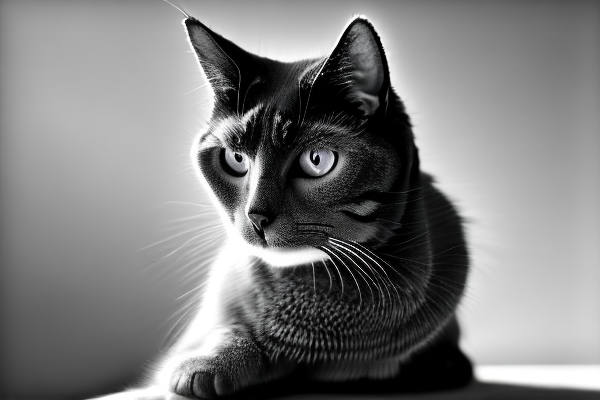

In [8]:
images[1]

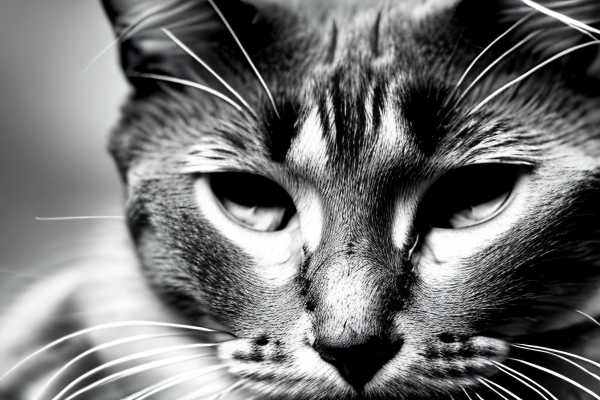

In [9]:
images[2]

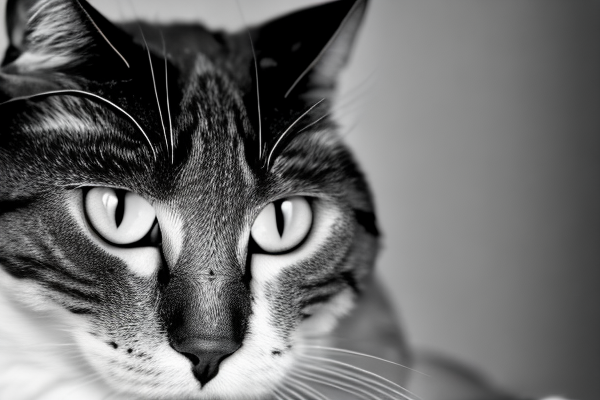

In [10]:
images[3]